In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import pickle
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd

df = pd.read_excel('/content/cleaned.csv.xlsx')
display(df.head())

,Order ID,Ship Mode,Customer ID,Segment,City,State,Region,Category,Sub-Category,Product Name,...,Order Date,Ship Date,Customer Feedback,Coupon Code,Returned,Payment Mode,Delivery Status,Rating,Promo Applied,Complaint
0,CA-2017-114636,Standard Class,GA-14725,Consumer,Charlotte,North Carolina,South,Office Supplies,Paper,Xerox 1910,...,2020-06-27,2020-07-03,NaN,NEW20,NaN,NaN,Delayed,4.0,1.0,NaN
1,US-2016-120460,Standard Class,BF-11170,Home Office,Dallas,Texas,Central,Furniture,Furnishings,Flat Face Poster Frame,...,2018-04-12,2018-04-15,Average,SAVE10,NaN,UPI,Delayed,NaN,NaN,NaN
2,CA-2016-157749,Second Class,KL-16645,Consumer,Chicago,Illinois,Central,Office Supplies,Art,Binney & Smith Crayola Metallic Colored Pencil...,...,2020-03-27,2020-03-30,Average,SAVE10,No,Wallet,Delivered,5.0,NaN,No
3,US-2014-137869,Standard Class,CV-12295,Consumer,Des Moines,Iowa,Central,Office Supplies,Envelopes,Poly String Tie Envelopes,...,2018-08-10,2018-08-19,Bad,NEW20,NaN,Wallet,NaN,3.0,0.0,NaN
4,CA-2017-117401,Second Class,PP-18955,Home Office,Springfield,Missouri,Central,Technology,Phones,Motorola HK250 Universal Bluetooth Headset,...,2019-05-30,2019-06-07,Excellent,SAVE10,Yes,Credit Card,Delivered,4.0,1.0,Yes


In [4]:
# Quick missing-value table (counts & percent) - helpful to prioritize columns to clean/drop
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_summary = pd.concat([missing, missing_pct], axis=1)
missing_summary.columns = ['missing_count', 'missing_pct']
print("missing_summary (top 30):")
print(missing_summary.head(30))

missing_summary (top 30):
                   missing_count  missing_pct
Complaint                   3393        33.95
Returned                    3360        33.62
Promo Applied               3346        33.48
Delivery Status             2473        24.74
Coupon Code                 2070        20.71
Payment Mode                1993        19.94
Customer Feedback           1960        19.61
Rating                      1636        16.37
Category                       0         0.00
Region                         0         0.00
State                          0         0.00
City                           0         0.00
Segment                        0         0.00
Customer ID                    0         0.00
Ship Mode                      0         0.00
Order ID                       0         0.00
Ship Date                      0         0.00
Order Date                     0         0.00
Profit                         0         0.00
Discount                       0         0.00
Quantity

In [5]:
# 1. Numeric columns
# ---------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        if col in ['discount']:
            # Missing discount → assume 0 (no discount applied)
            df[col] = df[col].fillna(0)
        elif col in ['rating']:
            # Rating → impute with median (robust to skew)
            df[col] = df[col].fillna(df[col].median())
        else:
            # General numeric → impute with mean
            df[col] = df[col].fillna(df[col].mean())

In [6]:
# 2. Categorical columns
# ---------------------------
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in cat_cols:
    if df[col].isnull().sum() > 0:
        if col in ['returned', 'complaint']:
            # Flags → assume 'No'
            df[col] = df[col].fillna('No')
        elif col in ['coupon_code', 'payment_mode', 'warehouse', 'agent_name']:
            # Operational fields → Unknown placeholder
            df[col] = df[col].fillna('Unknown')
        else:
            # General categorical → mode (most frequent value)
            df[col] = df[col].fillna(df[col].mode()[0])

In [7]:
# 3. Date columns
# ---------------------------
date_cols = [c for c in df.columns if "date" in c.lower()]

for col in date_cols:
    if df[col].isnull().sum() > 0:
        # Fill missing dates with the most frequent (mode)
        df[col] = pd.to_datetime(df[col], errors='coerce')
        common_date = df[col].mode()[0]
        df[col] = df[col].fillna(common_date)

# ---------------------------
# Final check
# ---------------------------
print("Missing values after filling:\n", df.isnull().sum().sort_values(ascending=False).head(15))

# Save cleaned file
df.to_csv("Superstore_Filled.csv", index=False)
print("✅ Cleaned dataset saved as Superstore_Filled.csv")

Missing values after filling:
 Order ID        0
Ship Mode       0
Customer ID     0
Segment         0
City            0
State           0
Region          0
Category        0
Sub-Category    0
Product Name    0
Sales           0
Quantity        0
Discount        0
Profit          0
Order Date      0
dtype: int64
✅ Cleaned dataset saved as Superstore_Filled.csv


In [20]:
# ================================================
# 📊 Enhanced EDA + ML Pipeline for Superstore Data
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ----------------------------
# 1. Load Data
# WHY: Always start by reading and inspecting the dataset
# ----------------------------
df = pd.read_csv("Superstore_Filled.csv")
print("Shape:", df.shape)
print(df.head())

# ----------------------------
# 2. Basic Info
# WHY: Check datatypes and nulls to plan preprocessing
# ----------------------------
print(df.info())
print(df.describe().T)

# ----------------------------
# 3. Handle Missing Values
# WHY: Missing values cause errors in aggregation and ML
# Strategy:
# - Discount: fill with 0 (no discount applied)
# - Rating: fill with median (central tendency)
# - Categorical: fill with 'Unknown'
# ----------------------------
if 'Discount' in df.columns:
    df['Discount'] = df['Discount'].fillna(0)

if 'Rating' in df.columns:
    df['Rating'] = df['Rating'].fillna(df['Rating'].median())

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('Unknown')

print("✅ Missing values handled.")




Shape: (9994, 24)
         Order ID       Ship Mode Customer ID      Segment         City  \
0  CA-2017-114636  Standard Class    GA-14725     Consumer    Charlotte   
1  US-2016-120460  Standard Class    BF-11170  Home Office       Dallas   
2  CA-2016-157749    Second Class    KL-16645     Consumer      Chicago   
3  US-2014-137869  Standard Class    CV-12295     Consumer   Des Moines   
4  CA-2017-117401    Second Class    PP-18955  Home Office  Springfield   

            State   Region         Category Sub-Category  \
0  North Carolina    South  Office Supplies        Paper   
1           Texas  Central        Furniture  Furnishings   
2        Illinois  Central  Office Supplies          Art   
3            Iowa  Central  Office Supplies    Envelopes   
4        Missouri  Central       Technology       Phones   

                                        Product Name  ...  Order Date  \
0                                         Xerox 1910  ...  2020-06-27   
1                       

In [11]:
# ----------------------------
# 4. Feature Engineering
# WHY: Derive meaningful business metrics
# ----------------------------
# Profitability flag (target variable)
df['profitable'] = np.where(df['Profit'] > 0, 1, 0)

# Profit margin
df['profit_margin'] = np.where(df['Sales'] > 0, df['Profit']/df['Sales'], 0)

# Ship duration
if 'Order Date' in df.columns and 'Ship Date' in df.columns:
    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
    df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')
    df['ship_duration'] = (df['Ship Date'] - df['Order Date']).dt.days

# Discount band
def discount_band(x):
    if x == 0: return 'No Discount'
    elif x <= 0.1: return 'Low'
    elif x <= 0.3: return 'Medium'
    else: return 'High'
df['discount_band'] = df['Discount'].apply(discount_band)

print("✅ Feature engineering done.")

✅ Feature engineering done.


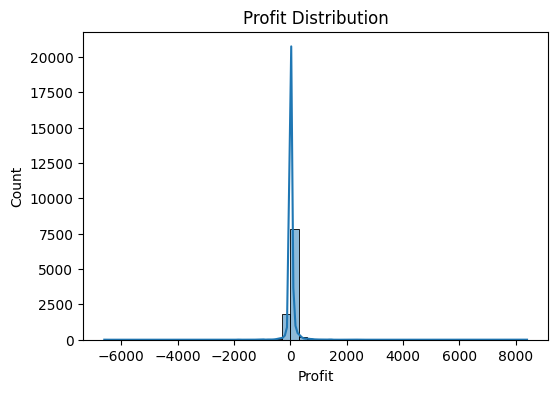

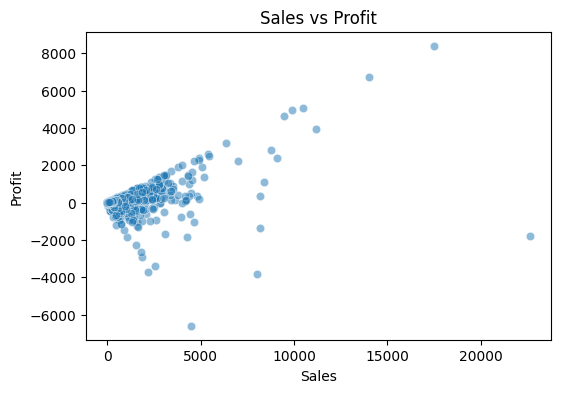

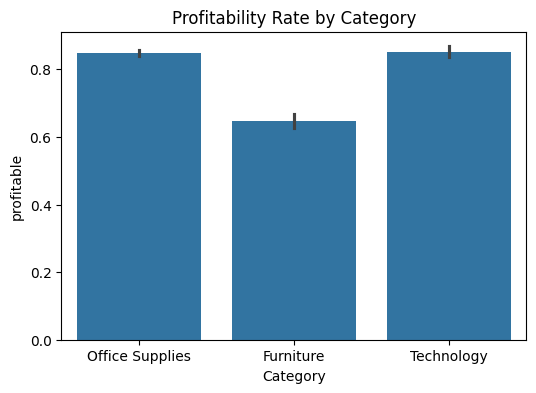

In [12]:
# 5. EDA (Exploratory Data Analysis)
# WHY: Understand distributions and business patterns
# ----------------------------

# Distribution of profit
plt.figure(figsize=(6,4))
sns.histplot(df['Profit'], bins=50, kde=True)
plt.title("Profit Distribution")
plt.show()

# Sales vs Profit scatter
plt.figure(figsize=(6,4))
sns.scatterplot(x='Sales', y='Profit', data=df, alpha=0.5)
plt.title("Sales vs Profit")
plt.show()

# Profitability by Category
plt.figure(figsize=(6,4))
sns.barplot(x='Category', y='profitable', data=df, estimator=np.mean)
plt.title("Profitability Rate by Category")
plt.show()


In [13]:
# ----------------------------
# 6. Encoding
# WHY: ML models need numeric data
# Strategy:
# - Label encode simple categoricals (Segment, Region, etc.)
# - One-hot encode discount band
# ----------------------------
label_enc = LabelEncoder()
for col in ['Segment','Region','Ship Mode']:
    if col in df.columns:
        df[col] = label_enc.fit_transform(df[col])

df = pd.get_dummies(df, columns=['discount_band'], drop_first=True)

print("✅ Encoding done.")


✅ Encoding done.


In [14]:
# ----------------------------
# 7. Scaling / Normalization
# WHY: Features have different scales (e.g., Sales in 1000s, Discount in 0-1)
# - StandardScaler: mean=0, std=1 (for ML stability)
# - MinMaxScaler: 0-1 scaling (optional for comparison)
# ----------------------------
scale_cols = ['Sales','Quantity','Discount','profit_margin','ship_duration']
scale_cols = [c for c in scale_cols if c in df.columns]

scaler_std = StandardScaler()
df_std = df.copy()
df_std[scale_cols] = scaler_std.fit_transform(df_std[scale_cols])

scaler_mm = MinMaxScaler()
df_mm = df.copy()
df_mm[scale_cols] = scaler_mm.fit_transform(df_mm[scale_cols])

print("✅ Scaling done.")

✅ Scaling done.


In [15]:
# 8. Train-Test Split
# WHY: Split data to evaluate ML model performance
# ----------------------------
X = df_std.drop(['Profit','profitable','Order Date','Ship Date', 'Order ID', 'Customer ID', 'City', 'State', 'Sub-Category', 'Product Name', 'Customer Feedback', 'Coupon Code', 'Returned', 'Payment Mode', 'Delivery Status', 'Promo Applied', 'Complaint', 'Category'], axis=1, errors='ignore')
y = df_std['profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:

# ----------------------------
# 9. Train Model
# WHY: Predict if an order is Profitable (1) or Not (0)
# Using RandomForest (handles non-linear patterns, good for mixed data)
# ----------------------------
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)


📌 Model Performance:
Accuracy: 1.0

Classification Report:
                 precision    recall  f1-score   support

Not Profitable       1.00      1.00      1.00       387
    Profitable       1.00      1.00      1.00      1612

      accuracy                           1.00      1999
     macro avg       1.00      1.00      1.00      1999
  weighted avg       1.00      1.00      1.00      1999



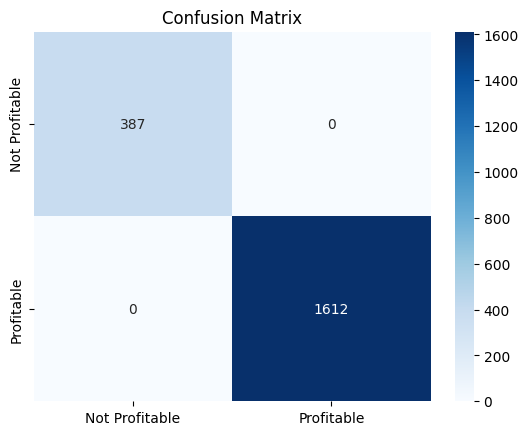

In [18]:
# ----------------------------
# 10. Evaluate Model
# WHY: Check accuracy, precision, recall (important for business risk)
# ----------------------------
y_pred = clf.predict(X_test)

print("\n📌 Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Not Profitable','Profitable']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Profitable','Profitable'], yticklabels=['Not Profitable','Profitable'])
plt.title("Confusion Matrix")
plt.show()


📌 Top 10 Important Features:
 profit_margin                0.551624
Discount                     0.174291
discount_band_No Discount    0.101790
discount_band_No Discount    0.083287
Sales                        0.022444
discount_band_Medium         0.019366
discount_band_Medium         0.017665
Region                       0.011252
Quantity                     0.005038
ship_duration                0.003968
dtype: float64


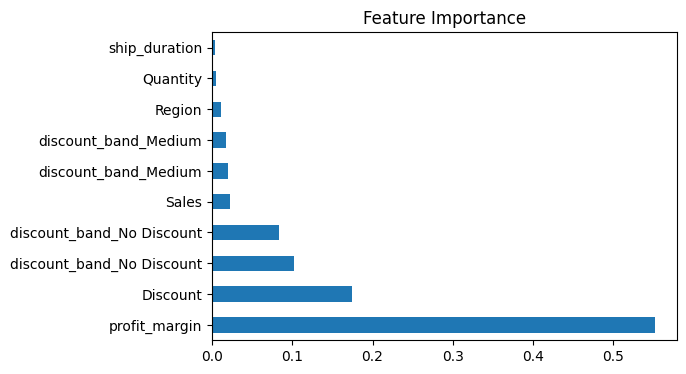

In [19]:
# ----------------------------
# 11. Feature Importance
# WHY: Explain which features drive profitability (business insight)
# ----------------------------
feat_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
print("\n📌 Top 10 Important Features:\n", feat_imp)

feat_imp.plot(kind='barh', figsize=(6,4), title="Feature Importance")
plt.show()